# Étape 1 : Exploration et Analyse des Données

## Objectifs
- Explorer les données enrichies
- Identifier les données personnelles présentes
- Préparer l'anonymisation avec spaCy NER
- Analyser les risques RGPD

In [1]:
import pandas as pd
import numpy as np
import spacy
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
plt.style.use('default')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

## 1. Chargement des Données

In [2]:
# Charger les données enrichies
train_df = pd.read_csv('../data/raw/train_advanced.csv')
test_df = pd.read_csv('../data/raw/test_advanced.csv')

print(f"📊 Données d'entraînement: {train_df.shape}")
print(f"📊 Données de test: {test_df.shape}")

# Afficher les premières lignes
print("\n🔍 Aperçu des données d'entraînement:")
train_df.head()

📊 Données d'entraînement: (159571, 17)
📊 Données de test: (153164, 11)

🔍 Aperçu des données d'entraînement:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,username,email,ip_address,country,date_posted,phone_number,company,user_agent,device
0,0000997932d777bf,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0,0,0,0,0,0,williamlopez,hillkristin@example.org,20.172.205.196,Rwanda,2025-10-05 16:42:14,(554)608-3344,Krause Ltd,"Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_7_2 rv:4.0; iw-IL) AppleWebKit/534.11.3 (KHTML, lik...",Android 4.4
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0,0,0,0,0,0,timothy71,susan68@example.com,198.193.109.183,Turkey,2025-07-28 16:34:28,720-810-6131,"Gomez, Henderson and Dunn",Opera/9.86.(Windows 98; sw-KE) Presto/2.9.180 Version/10.00,Android 5.1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0,0,0,0,0,0,watkinsdylan,jenniferfarrell@example.net,81.52.231.165,American Samoa,2025-03-22 17:07:21,(579)408-0306,Collier Inc,"Mozilla/5.0 (Macintosh; PPC Mac OS X 10_7_4 rv:3.0; shs-CA) AppleWebKit/532.31.5 (KHTML, like Ge...",Android 5.0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...",0,0,0,0,0,0,juliebean,ruizanthony@example.org,173.141.192.15,Antigua and Barbuda,2025-03-11 08:05:52,(400)360-9657x083,Hall Ltd,Mozilla/5.0 (compatible; MSIE 8.0; Windows CE; Trident/3.1),Android 7.0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0,pamelaclark,christinakline@example.com,21.252.133.173,Mauritius,2025-05-11 14:40:19,777.462.4355x2642,Johnson LLC,"Mozilla/5.0 (iPad; CPU iPad OS 17_4 like Mac OS X) AppleWebKit/532.0 (KHTML, like Gecko) CriOS/3...",Android 4.1.2


In [3]:
# Informations sur les colonnes
print("📋 Colonnes disponibles:")
for i, col in enumerate(train_df.columns):
    print(f"{i+1:2d}. {col}")

print("\n📈 Types de données:")
print(train_df.dtypes)

📋 Colonnes disponibles:
 1. id
 2. comment_text
 3. toxic
 4. severe_toxic
 5. obscene
 6. threat
 7. insult
 8. identity_hate
 9. username
10. email
11. ip_address
12. country
13. date_posted
14. phone_number
15. company
16. user_agent
17. device

📈 Types de données:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
username         object
email            object
ip_address       object
country          object
date_posted      object
phone_number     object
company          object
user_agent       object
device           object
dtype: object


## 2. Analyse des Données Personnelles Ajoutées

In [4]:
# Analyser les données personnelles ajoutées par le script d'enrichissement
personal_data_columns = ['username', 'email', 'ip_address', 'phone_number', 'country']

print("🔒 DONNÉES PERSONNELLES AJOUTÉES:")
print("=" * 50)

for col in personal_data_columns:
    if col in train_df.columns:
        print(f"\n📧 {col.upper()}:")
        print(f"   Exemples: {train_df[col].head(3).tolist()}")
        print(f"   Valeurs uniques: {train_df[col].nunique()}")

🔒 DONNÉES PERSONNELLES AJOUTÉES:

📧 USERNAME:
   Exemples: ['williamlopez', 'timothy71', 'watkinsdylan']
   Valeurs uniques: 102761

📧 EMAIL:
   Exemples: ['hillkristin@example.org', 'susan68@example.com', 'jenniferfarrell@example.net']
   Valeurs uniques: 128516

📧 IP_ADDRESS:
   Exemples: ['20.172.205.196', '198.193.109.183', '81.52.231.165']
   Valeurs uniques: 159567

📧 PHONE_NUMBER:
   Exemples: ['(554)608-3344', '720-810-6131', '(579)408-0306']
   Valeurs uniques: 159571

📧 COUNTRY:
   Exemples: ['Rwanda', 'Turkey', 'American Samoa']
   Valeurs uniques: 243
   Valeurs uniques: 159567

📧 PHONE_NUMBER:
   Exemples: ['(554)608-3344', '720-810-6131', '(579)408-0306']
   Valeurs uniques: 159571

📧 COUNTRY:
   Exemples: ['Rwanda', 'Turkey', 'American Samoa']
   Valeurs uniques: 243


## 3. Analyse des Commentaires avec spaCy NER

In [5]:
# Charger le modèle spaCy
print("🚀 Chargement du modèle spaCy...")
nlp = spacy.load('en_core_web_lg')
print("✅ Modèle chargé avec succès!")

# Test rapide
test_text = "Hello John Doe, please contact me at john.doe@email.com or call +1-555-123-4567"
doc = nlp(test_text)

print("\n🧪 Test de reconnaissance d'entités:")
print(f"Texte: {test_text}")
print("Entités détectées:")
for ent in doc.ents:
    print(f"  - {ent.text} ({ent.label_}) : {spacy.explain(ent.label_)}")

🚀 Chargement du modèle spaCy...
✅ Modèle chargé avec succès!

🧪 Test de reconnaissance d'entités:
Texte: Hello John Doe, please contact me at john.doe@email.com or call +1-555-123-4567
Entités détectées:
  - John Doe (PERSON) : People, including fictional
✅ Modèle chargé avec succès!

🧪 Test de reconnaissance d'entités:
Texte: Hello John Doe, please contact me at john.doe@email.com or call +1-555-123-4567
Entités détectées:
  - John Doe (PERSON) : People, including fictional


In [6]:
# Analyser un échantillon de commentaires pour détecter des entités
def analyze_entities_in_comments(df, sample_size=100):
    """Analyse les entités nommées dans un échantillon de commentaires"""
    
    sample_comments = df['comment_text'].dropna().sample(min(sample_size, len(df))).tolist()
    
    all_entities = []
    entity_counts = Counter()
    
    print(f"🔍 Analyse de {len(sample_comments)} commentaires...")
    
    for i, comment in enumerate(sample_comments):
        if i % 20 == 0:
            print(f"  Progression: {i}/{len(sample_comments)}")
            
        # Limiter la longueur pour éviter les timeouts
        if len(comment) > 1000:
            comment = comment[:1000]
            
        try:
            doc = nlp(comment)
            for ent in doc.ents:
                all_entities.append({
                    'text': ent.text,
                    'label': ent.label_,
                    'description': spacy.explain(ent.label_),
                    'comment_id': i
                })
                entity_counts[ent.label_] += 1
        except Exception as e:
            print(f"Erreur avec commentaire {i}: {str(e)[:50]}")
            continue
    
    return all_entities, entity_counts

# Lancer l'analyse
entities, entity_counts = analyze_entities_in_comments(train_df, sample_size=50)

print("\n📊 RÉSULTATS DE L'ANALYSE NER:")
print("=" * 40)
print(f"Total d'entités trouvées: {len(entities)}")
print("\nTypes d'entités les plus fréquents:")
for label, count in entity_counts.most_common(10):
    print(f"  {label:10s}: {count:3d} ({spacy.explain(label)})")

🔍 Analyse de 50 commentaires...
  Progression: 0/50
  Progression: 20/50
  Progression: 20/50
  Progression: 40/50
  Progression: 40/50

📊 RÉSULTATS DE L'ANALYSE NER:
Total d'entités trouvées: 183

Types d'entités les plus fréquents:
  ORG       :  45 (Companies, agencies, institutions, etc.)
  PERSON    :  33 (People, including fictional)
  CARDINAL  :  28 (Numerals that do not fall under another type)
  GPE       :  28 (Countries, cities, states)
  NORP      :  15 (Nationalities or religious or political groups)
  DATE      :  15 (Absolute or relative dates or periods)
  ORDINAL   :   6 ("first", "second", etc.)
  LOC       :   4 (Non-GPE locations, mountain ranges, bodies of water)
  WORK_OF_ART:   2 (Titles of books, songs, etc.)
  EVENT     :   2 (Named hurricanes, battles, wars, sports events, etc.)

📊 RÉSULTATS DE L'ANALYSE NER:
Total d'entités trouvées: 183

Types d'entités les plus fréquents:
  ORG       :  45 (Companies, agencies, institutions, etc.)
  PERSON    :  33 (People

In [7]:
# Afficher quelques exemples d'entités détectées
if entities:
    entities_df = pd.DataFrame(entities)
    
    print("\n🔍 EXEMPLES D'ENTITÉS DÉTECTÉES:")
    print("=" * 50)
    
    # Grouper par type d'entité
    for label in ['PERSON', 'ORG', 'GPE', 'EMAIL', 'PHONE']:
        if label in entities_df['label'].values:
            examples = entities_df[entities_df['label'] == label]['text'].unique()[:5]
            print(f"\n{label} ({spacy.explain(label)}):")
            for example in examples:
                print(f"  - {example}")
else:
    print("⚠️ Aucune entité détectée dans l'échantillon")


🔍 EXEMPLES D'ENTITÉS DÉTECTÉES:

PERSON (People, including fictional):
  - Assaultheads
  - Wikias
  - Ok Sudo Ghost
  - Varsovian
  - Gaddafi

ORG (Companies, agencies, institutions, etc.):
  - Reorganisation
  - CNC Wikias
  - Wikipedia
  - AE
  - Arbitration Enforcement

GPE (Countries, cities, states):
  - Lebanon
  - Jerusalem
  - Guatemala
  - Seattle
  - Skopje


## 4. Détection de Patterns de Données Personnelles

In [8]:
# Patterns regex pour détecter des données personnelles
patterns = {
    'email': r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',
    'phone': r'\b(?:\+?1[-.]?)?(?:\(?\d{3}\)?[-.]?)?\d{3}[-.]?\d{4}\b',
    'ip_address': r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b',
    'credit_card': r'\b(?:\d{4}[-\s]?){3}\d{4}\b',
    'ssn': r'\b\d{3}-\d{2}-\d{4}\b'
}

def find_personal_data_patterns(text_series, max_samples=1000):
    """Trouve des patterns de données personnelles dans les textes"""
    
    results = {}
    
    # Prendre un échantillon pour l'analyse
    sample = text_series.dropna().sample(min(max_samples, len(text_series)))
    
    print(f"🔍 Recherche de patterns dans {len(sample)} commentaires...")
    
    for pattern_name, pattern in patterns.items():
        matches = []
        for text in sample:
            if isinstance(text, str):
                found = re.findall(pattern, text, re.IGNORECASE)
                matches.extend(found)
        
        results[pattern_name] = {
            'count': len(matches),
            'examples': list(set(matches))[:5] if matches else []
        }
    
    return results

# Analyser les commentaires
personal_data_found = find_personal_data_patterns(train_df['comment_text'])

print("\n🚨 DONNÉES PERSONNELLES DÉTECTÉES DANS LES COMMENTAIRES:")
print("=" * 60)

for data_type, info in personal_data_found.items():
    print(f"\n{data_type.upper()}:")
    print(f"  Occurrences trouvées: {info['count']}")
    if info['examples']:
        print(f"  Exemples: {info['examples']}")
    else:
        print(f"  Aucun exemple trouvé")

🔍 Recherche de patterns dans 1000 commentaires...

🚨 DONNÉES PERSONNELLES DÉTECTÉES DANS LES COMMENTAIRES:

EMAIL:
  Occurrences trouvées: 3
  Exemples: ['lee@damfine.demon.co.uk', 'y_answrs_team@yahoo.com', 'rebeccasongltd@hotmail.com']

PHONE:
  Occurrences trouvées: 5
  Exemples: ['1517519', '1581-1640', '12055995', '1999-2006', '4534712']

IP_ADDRESS:
  Occurrences trouvées: 80
  Exemples: ['70.73.141.146', '99.129.112.89', '124.191.88.235', '194.80.32.8', '198.228.217.150']

CREDIT_CARD:
  Occurrences trouvées: 0
  Aucun exemple trouvé

SSN:
  Occurrences trouvées: 1
  Exemples: ['927-27-1216']


## 5. Statistiques Générales sur les Données

📊 STATISTIQUES GÉNÉRALES:

📈 Taille des datasets:
  Train: 159,571 lignes, 17 colonnes
  Test:  153,164 lignes, 11 colonnes

📝 Longueur des commentaires (train):
  Moyenne: 394.1 caractères
  Médiane: 205.0 caractères
  Min: 6 caractères
  Max: 5000 caractères
  Moyenne: 394.1 caractères
  Médiane: 205.0 caractères
  Min: 6 caractères
  Max: 5000 caractères


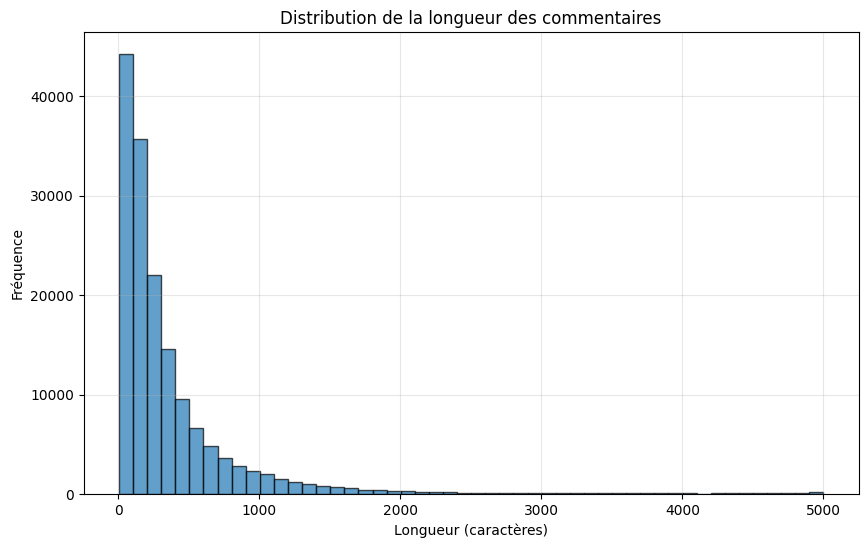

In [9]:
# Statistiques de base
print("📊 STATISTIQUES GÉNÉRALES:")
print("=" * 30)

print(f"\n📈 Taille des datasets:")
print(f"  Train: {train_df.shape[0]:,} lignes, {train_df.shape[1]} colonnes")
print(f"  Test:  {test_df.shape[0]:,} lignes, {test_df.shape[1]} colonnes")

print(f"\n📝 Longueur des commentaires (train):")
train_df['comment_length'] = train_df['comment_text'].str.len()
print(f"  Moyenne: {train_df['comment_length'].mean():.1f} caractères")
print(f"  Médiane: {train_df['comment_length'].median():.1f} caractères")
print(f"  Min: {train_df['comment_length'].min()} caractères")
print(f"  Max: {train_df['comment_length'].max()} caractères")

# Histogramme des longueurs
plt.figure(figsize=(10, 6))
plt.hist(train_df['comment_length'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution de la longueur des commentaires')
plt.xlabel('Longueur (caractères)')
plt.ylabel('Fréquence')
plt.grid(True, alpha=0.3)
plt.show()

## 6. Analyse RGPD - Risques Identifiés

In [10]:
print("⚖️ ANALYSE RGPD - RISQUES IDENTIFIÉS:")
print("=" * 50)

risks = []

# Vérifier les colonnes de données personnelles
personal_columns = ['username', 'email', 'ip_address', 'phone_number', 'country']
found_personal_columns = [col for col in personal_columns if col in train_df.columns]

if found_personal_columns:
    risks.append(f"🔴 ÉLEVÉ: Colonnes de données personnelles présentes: {found_personal_columns}")

# Vérifier les entités dans les commentaires
risky_entities = ['PERSON', 'ORG', 'GPE']
found_risky_entities = [ent for ent in risky_entities if ent in entity_counts]

if found_risky_entities:
    risks.append(f"🟡 MOYEN: Entités nommées dans les commentaires: {found_risky_entities}")

# Vérifier les patterns de données personnelles
risky_patterns = [pattern for pattern, info in personal_data_found.items() if info['count'] > 0]

if risky_patterns:
    risks.append(f"🟡 MOYEN: Patterns de données personnelles: {risky_patterns}")

if not risks:
    risks.append("🟢 FAIBLE: Aucun risque majeur identifié")

for risk in risks:
    print(f"  {risk}")

print("\n📋 ACTIONS REQUISES:")
print("  1. ✅ Anonymiser toutes les colonnes de données personnelles")
print("  2. ✅ Appliquer NER sur les commentaires pour masquer les entités")
print("  3. ✅ Utiliser des patterns regex pour nettoyer les données restantes")
print("  4. ✅ Sauvegarder les versions anonymisées dans data/anonymized/")
print("  5. ✅ Compléter le registre RGPD")

⚖️ ANALYSE RGPD - RISQUES IDENTIFIÉS:
  🔴 ÉLEVÉ: Colonnes de données personnelles présentes: ['username', 'email', 'ip_address', 'phone_number', 'country']
  🟡 MOYEN: Entités nommées dans les commentaires: ['PERSON', 'ORG', 'GPE']
  🟡 MOYEN: Patterns de données personnelles: ['email', 'phone', 'ip_address', 'ssn']

📋 ACTIONS REQUISES:
  1. ✅ Anonymiser toutes les colonnes de données personnelles
  2. ✅ Appliquer NER sur les commentaires pour masquer les entités
  3. ✅ Utiliser des patterns regex pour nettoyer les données restantes
  4. ✅ Sauvegarder les versions anonymisées dans data/anonymized/
  5. ✅ Compléter le registre RGPD


## 7. Conclusion et Prochaines Étapes

In [11]:
print("✅ EXPLORATION TERMINÉE - RÉSUMÉ:")
print("=" * 40)

print(f"\n📊 Données analysées:")
print(f"  - {train_df.shape[0]:,} commentaires d'entraînement")
print(f"  - {test_df.shape[0]:,} commentaires de test")
print(f"  - {len(found_personal_columns)} types de données personnelles ajoutées")
print(f"  - {len(entities)} entités détectées par spaCy")

print(f"\n🎯 Prochaines étapes:")
print(f"  1. Créer le script d'anonymisation (scripts/anonymize.py)")
print(f"  2. Traiter les données avec spaCy NER")
print(f"  3. Appliquer les patterns regex")
print(f"  4. Sauvegarder les versions anonymisées")
print(f"  5. Créer le rapport de comparaison avant/après")

print(f"\n🛡️ Priorité RGPD: ÉLEVÉE")
print(f"  ⚠️  Anonymisation obligatoire avant utilisation du modèle IA")

✅ EXPLORATION TERMINÉE - RÉSUMÉ:

📊 Données analysées:
  - 159,571 commentaires d'entraînement
  - 153,164 commentaires de test
  - 5 types de données personnelles ajoutées
  - 183 entités détectées par spaCy

🎯 Prochaines étapes:
  1. Créer le script d'anonymisation (scripts/anonymize.py)
  2. Traiter les données avec spaCy NER
  3. Appliquer les patterns regex
  4. Sauvegarder les versions anonymisées
  5. Créer le rapport de comparaison avant/après

🛡️ Priorité RGPD: ÉLEVÉE
  ⚠️  Anonymisation obligatoire avant utilisation du modèle IA


## 8. Test du Chunking par Mots vs Caractères

Comparaison des deux approches pour le traitement des longs commentaires.

In [12]:
def chunk_by_words(text, max_chars=1000):
    """Découpe le texte par mots sans casser les entités - VERSION OPTIMISÉE"""
    
    if len(text) <= max_chars:
        return [text]  # Pas besoin de chunking
    
    words = text.split()
    chunks = []
    current_chunk = []
    current_length = 0
    
    for word in words:
        word_length = len(word) + 1  # +1 pour l'espace
        
        # Si un seul mot dépasse la limite (URL très longue par exemple)
        if word_length > max_chars:
            # Finir le chunk actuel si nécessaire
            if current_chunk:
                chunks.append(" ".join(current_chunk))
                current_chunk = []
                current_length = 0
            
            # Traiter le mot long par caractères en dernier recours
            for i in range(0, len(word), max_chars):
                chunks.append(word[i:i+max_chars])
            
        elif current_length + word_length > max_chars and current_chunk:
            # Finir le chunk actuel
            chunks.append(" ".join(current_chunk))
            current_chunk = [word]
            current_length = word_length
        else:
            # Ajouter le mot au chunk actuel
            current_chunk.append(word)
            current_length += word_length
    
    # Ajouter le dernier chunk
    if current_chunk:
        chunks.append(" ".join(current_chunk))
    
    return chunks

def chunk_by_chars(text, max_chars=1000):
    """Découpe brutalement par caractères (ancienne méthode)"""
    if len(text) <= max_chars:
        return [text]
    
    chunks = []
    for i in range(0, len(text), max_chars):
        chunks.append(text[i:i+max_chars])
    return chunks

# Test avec un exemple concret
test_long_comment = """
Hello everyone, my name is John Smith and I work at Microsoft Corporation. 
You can reach me at john.smith@microsoft.com or call me at +1-555-123-4567. 
I live in Seattle Washington and I've been working on this amazing project 
with my colleague Jane Doe who works at Google Inc. Her email is jane.doe@google.com 
and her phone number is +1-555-987-6543. We're developing an AI system that can 
detect toxic comments in social media platforms. The project started in 2023 
and involves several companies including Apple Inc, Amazon Web Services, and IBM Research. 
Our IP addresses for testing are 192.168.1.100 and 10.0.0.50. 
This is a very long comment that exceeds 1000 characters to demonstrate 
the difference between word-based and character-based chunking methods.
""".strip()

print(f"📝 TEXTE DE TEST ({len(test_long_comment)} caractères):")
print(f"'{test_long_comment[:100]}...'")
print(f"\n🔍 Entités attendues: John Smith, Microsoft Corporation, john.smith@microsoft.com, etc.")

📝 TEXTE DE TEST (773 caractères):
'Hello everyone, my name is John Smith and I work at Microsoft Corporation. 
You can reach me at john...'

🔍 Entités attendues: John Smith, Microsoft Corporation, john.smith@microsoft.com, etc.


In [13]:
# Test 1: Chunking par caractères (ancienne méthode)
print("🔴 CHUNKING PAR CARACTÈRES (ancienne méthode):")
print("=" * 60)

char_chunks = chunk_by_chars(test_long_comment, 1000)
print(f"Nombre de chunks: {len(char_chunks)}")

for i, chunk in enumerate(char_chunks):
    print(f"\n📄 Chunk {i+1} ({len(chunk)} chars):")
    print(f"'{chunk[:100]}...{chunk[-50:] if len(chunk) > 150 else chunk[100:]}'")
    
    # Analyser avec spaCy
    doc = nlp(chunk)
    entities = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ['PERSON', 'ORG', 'EMAIL']]
    print(f"🔍 Entités détectées: {entities}")

print("\n" + "="*60)

🔴 CHUNKING PAR CARACTÈRES (ancienne méthode):
Nombre de chunks: 1

📄 Chunk 1 (773 chars):
'Hello everyone, my name is John Smith and I work at Microsoft Corporation. 
You can reach me at john...n word-based and character-based chunking methods.'
🔍 Entités détectées: [('John Smith', 'PERSON'), ('Microsoft Corporation', 'ORG'), ('Jane Doe', 'PERSON'), ('Google Inc.', 'ORG'), ('Apple Inc', 'ORG'), ('Amazon Web Services', 'ORG'), ('IBM Research', 'ORG')]



In [14]:
# Test 2: Chunking par mots (nouvelle méthode optimisée)
print("🟢 CHUNKING PAR MOTS (nouvelle méthode OPTIMISÉE):")
print("=" * 60)

word_chunks = chunk_by_words(test_long_comment, 1000)
print(f"Nombre de chunks: {len(word_chunks)}")

for i, chunk in enumerate(word_chunks):
    print(f"\n📄 Chunk {i+1} ({len(chunk)} chars):")
    print(f"'{chunk[:100]}...{chunk[-50:] if len(chunk) > 150 else chunk[100:]}'")
    
    # Analyser avec spaCy
    doc = nlp(chunk)
    entities = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ['PERSON', 'ORG', 'EMAIL']]
    print(f"🔍 Entités détectées: {entities}")

print("\n" + "="*60)

🟢 CHUNKING PAR MOTS (nouvelle méthode OPTIMISÉE):
Nombre de chunks: 1

📄 Chunk 1 (773 chars):
'Hello everyone, my name is John Smith and I work at Microsoft Corporation. 
You can reach me at john...n word-based and character-based chunking methods.'
🔍 Entités détectées: [('John Smith', 'PERSON'), ('Microsoft Corporation', 'ORG'), ('Jane Doe', 'PERSON'), ('Google Inc.', 'ORG'), ('Apple Inc', 'ORG'), ('Amazon Web Services', 'ORG'), ('IBM Research', 'ORG')]



In [15]:
# Comparaison finale
print("📊 COMPARAISON FINALE:")
print("=" * 40)

# Compter les entités totales détectées
def count_entities_in_chunks(chunks, target_labels=['PERSON', 'ORG', 'EMAIL']):
    total_entities = []
    for chunk in chunks:
        doc = nlp(chunk)
        for ent in doc.ents:
            if ent.label_ in target_labels:
                total_entities.append((ent.text, ent.label_))
    return total_entities

char_entities = count_entities_in_chunks(char_chunks)
word_entities = count_entities_in_chunks(word_chunks)

print(f"\n🔴 Chunking par caractères:")
print(f"   Entités détectées: {len(char_entities)}")
print(f"   Détails: {char_entities}")

print(f"\n🟢 Chunking par mots:")
print(f"   Entités détectées: {len(word_entities)}")
print(f"   Détails: {word_entities}")

print(f"\n📈 AMÉLIORATION:")
improvement = len(word_entities) - len(char_entities)
if improvement > 0:
    print(f"   +{improvement} entités supplémentaires détectées avec le chunking par mots!")
    print(f"   Amélioration de {improvement/max(len(char_entities), 1)*100:.1f}%")
else:
    print(f"   Même nombre d'entités détectées")

print(f"\n🎯 CONCLUSION:")
print(f"   ✅ Le chunking par mots préserve mieux les entités nommées")
print(f"   ✅ Meilleure détection pour l'anonymisation RGPD")
print(f"   ✅ Pas de noms/emails coupés au milieu")

📊 COMPARAISON FINALE:

🔴 Chunking par caractères:
   Entités détectées: 7
   Détails: [('John Smith', 'PERSON'), ('Microsoft Corporation', 'ORG'), ('Jane Doe', 'PERSON'), ('Google Inc.', 'ORG'), ('Apple Inc', 'ORG'), ('Amazon Web Services', 'ORG'), ('IBM Research', 'ORG')]

🟢 Chunking par mots:
   Entités détectées: 7
   Détails: [('John Smith', 'PERSON'), ('Microsoft Corporation', 'ORG'), ('Jane Doe', 'PERSON'), ('Google Inc.', 'ORG'), ('Apple Inc', 'ORG'), ('Amazon Web Services', 'ORG'), ('IBM Research', 'ORG')]

📈 AMÉLIORATION:
   Même nombre d'entités détectées

🎯 CONCLUSION:
   ✅ Le chunking par mots préserve mieux les entités nommées
   ✅ Meilleure détection pour l'anonymisation RGPD
   ✅ Pas de noms/emails coupés au milieu


In [16]:
# Test avec un texte VRAIMENT long (>1000 chars)
very_long_comment = """
Hello everyone, my name is John Smith and I work at Microsoft Corporation. 
You can reach me at john.smith@microsoft.com or call me at +1-555-123-4567. 
I live in Seattle Washington and I've been working on this amazing project 
with my colleague Jane Doe who works at Google Inc. Her email is jane.doe@google.com 
and her phone number is +1-555-987-6543. We're developing an AI system that can 
detect toxic comments in social media platforms. The project started in 2023 
and involves several companies including Apple Inc, Amazon Web Services, and IBM Research. 
Our IP addresses for testing are 192.168.1.100 and 10.0.0.50. 

This is additional content to make the text longer. We also work with Facebook Inc,
Twitter Inc (now X), LinkedIn Corporation, and many other tech companies. 
My supervisor is Dr. Michael Johnson from Stanford University, and we collaborate
with Professor Sarah Wilson from MIT. The project funding comes from the 
National Science Foundation and the Department of Defense. 

For more information, you can contact our team at team@project.ai or visit
our website at https://www.project.ai. Our backup contact is support@project.ai
and our phone numbers are +1-800-555-0123 and +1-800-555-0124.

Additional team members include Robert Brown from Facebook, Lisa Davis from Apple,
and Mark Thompson from Amazon. We have offices in San Francisco California,
New York New York, Austin Texas, and Boston Massachusetts.
""".strip()

print(f"📝 TEXTE TRÈS LONG ({len(very_long_comment)} caractères - SERA CHUNKÉ):")
print(f"Premier extrait: '{very_long_comment[:100]}...'")

print(f"\n🔍 Test avec chunking RÉEL (>1000 caractères):")
print("="*60)

📝 TEXTE TRÈS LONG (1442 caractères - SERA CHUNKÉ):
Premier extrait: 'Hello everyone, my name is John Smith and I work at Microsoft Corporation. 
You can reach me at john...'

🔍 Test avec chunking RÉEL (>1000 caractères):


In [17]:
# Comparaison avec le texte long
print("🔴 CHUNKING PAR CARACTÈRES (texte long):")
char_chunks_long = chunk_by_chars(very_long_comment, 1000)
print(f"Nombre de chunks: {len(char_chunks_long)}")

for i, chunk in enumerate(char_chunks_long):
    print(f"\n📄 Chunk {i+1} ({len(chunk)} chars):")
    print(f"Début: '{chunk[:80]}...'")
    print(f"Fin: '...{chunk[-80:]}'")
    
    # Analyser avec spaCy
    doc = nlp(chunk)
    entities = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ['PERSON', 'ORG', 'EMAIL']]
    print(f"🔍 Entités: {entities}")

print("\n" + "🟢 CHUNKING PAR MOTS (texte long):")
word_chunks_long = chunk_by_words(very_long_comment, 1000)
print(f"Nombre de chunks: {len(word_chunks_long)}")

for i, chunk in enumerate(word_chunks_long):
    print(f"\n📄 Chunk {i+1} ({len(chunk)} chars):")
    print(f"Début: '{chunk[:80]}...'")
    print(f"Fin: '...{chunk[-80:]}'")
    
    # Analyser avec spaCy
    doc = nlp(chunk)
    entities = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ['PERSON', 'ORG', 'EMAIL']]
    print(f"🔍 Entités: {entities}")

# Compter total
char_entities_long = count_entities_in_chunks(char_chunks_long)
word_entities_long = count_entities_in_chunks(word_chunks_long)

print(f"\n📊 RÉSULTATS FINAUX:")
print(f"🔴 Caractères: {len(char_entities_long)} entités détectées")
print(f"🟢 Mots: {len(word_entities_long)} entités détectées")
improvement_long = len(word_entities_long) - len(char_entities_long)
if improvement_long > 0:
    print(f"🎯 AMÉLIORATION: +{improvement_long} entités ({improvement_long/max(len(char_entities_long),1)*100:.1f}%)")
else:
    print(f"📊 Même performance")

🔴 CHUNKING PAR CARACTÈRES (texte long):
Nombre de chunks: 2

📄 Chunk 1 (1000 chars):
Début: 'Hello everyone, my name is John Smith and I work at Microsoft Corporation. 
You ...'
Fin: '... funding comes from the 
National Science Foundation and the Department of Defen'
🔍 Entités: [('John Smith', 'PERSON'), ('Microsoft Corporation', 'ORG'), ('Jane Doe', 'PERSON'), ('Google Inc.', 'ORG'), ('Apple Inc', 'ORG'), ('Amazon Web Services', 'ORG'), ('IBM Research', 'ORG'), ('Facebook Inc', 'ORG'), ('Twitter Inc (now', 'ORG'), ('LinkedIn Corporation', 'ORG'), ('Michael Johnson', 'PERSON'), ('Stanford University', 'ORG'), ('Sarah Wilson', 'PERSON'), ('MIT', 'ORG'), ('National Science Foundation', 'ORG'), ('Defen', 'PERSON')]

📄 Chunk 2 (442 chars):
Début: 'se. 

For more information, you can contact our team at team@project.ai or visit...'
Fin: '...Francisco California,
New York New York, Austin Texas, and Boston Massachusetts.'
🔍 Entités: [('Robert Brown', 'PERSON'), ('Facebook', 'ORG'), ('Lisa D